In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno

from sklearn.preprocessing import LabelEncoder, minmax_scale,StandardScaler

from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold,mutual_info_classif,SelectKBest,SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import  RandomForestClassifier

from sklearn.model_selection import  GridSearchCV,cross_val_score,TimeSeriesSplit,cross_validate

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_auc_score,roc_curve, auc,matthews_corrcoef
from sklearn.metrics import  make_scorer,accuracy_score,precision_score,recall_score, f1_score,brier_score_loss,matthews_corrcoef


Reading csv files

In [3]:
identity = pd.read_csv ('train_identity.csv')
transaction = pd.read_csv ('train_transaction.csv')

In [4]:
transaction.shape

(590540, 394)

In [5]:
identity.shape

(144233, 41)

Merging transaction and identity files of dataset

In [6]:
#Merging both the files on the basis of TransactionID column(left outer join)
Data = pd.merge(transaction,identity, on='TransactionID', how='left',left_index=True,right_index=True)
print('MERGED')

MERGED


In [7]:
#Deleting tables since we merged it 
del transaction
del identity
print('DELETED')

DELETED


In [8]:
## Function to reduce the size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [9]:
## REducing memory
Data = reduce_mem_usage(Data)

Mem. usage decreased to 645.97 Mb (67.0% reduction)


INITIAL ANALYSIS

In [10]:
Data.shape

(590540, 434)

In [11]:
Data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [12]:
Data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 434 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int32  
 1   isFraud         590540 non-null  int8   
 2   TransactionDT   590540 non-null  int32  
 3   TransactionAmt  590540 non-null  float16
 4   ProductCD       590540 non-null  object 
 5   card1           590540 non-null  int16  
 6   card2           581607 non-null  float16
 7   card3           588975 non-null  float16
 8   card4           588963 non-null  object 
 9   card5           586281 non-null  float16
 10  card6           588969 non-null  object 
 11  addr1           524834 non-null  float16
 12  addr2           524834 non-null  float16
 13  dist1           238269 non-null  float16
 14  dist2           37627 non-null   float16
 15  P_emaildomain   496084 non-null  object 
 16  R_emaildomain   137291 non-null  object 
 17  C1       

In [13]:
# summary of columns
total_missing = Data.isnull().sum().sort_values(ascending = False)
percent_missing = (Data.isnull().sum()/Data.isnull().count()*100).sort_values(ascending = False)
datatype = Data.dtypes
unique = Data.nunique()
summary_train = pd.concat([total_missing, percent_missing,datatype,unique], axis=1, keys=['Total_missing', 'Percent_missing','datatype','unique'])
summary_train.head(50)

,Total_missing,Percent_missing,datatype,unique
id_24,585793,99.196159,float16,12
id_25,585408,99.130965,float16,341
id_07,585385,99.127070,float16,84
id_08,585385,99.127070,float16,94
id_21,585381,99.126393,float16,490
id_26,585377,99.125715,float16,95
id_22,585371,99.124699,float16,25
id_23,585371,99.124699,object,3
id_27,585371,99.124699,object,2
dist2,552913,93.628374,float16,1699


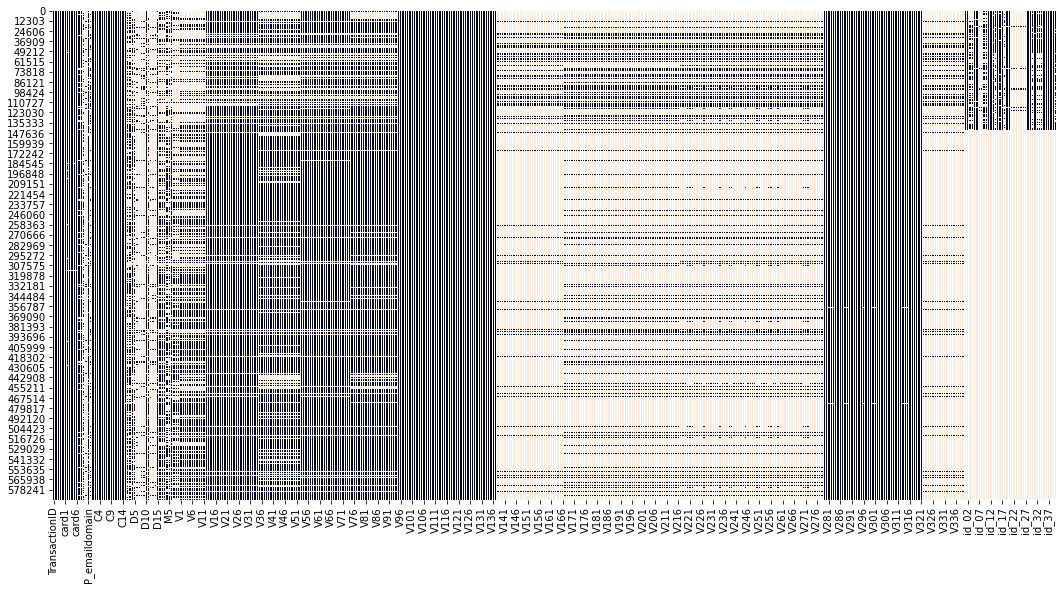

In [14]:
#plotting missing values in the dataset
plt.figure(figsize=(18,9))
sns.heatmap(Data.isnull(), cbar= False)

In [15]:
#variables with missing values
variables_missingvalues = [var for var in Data.columns if Data[var].isnull().mean() > 0]
variables_missingvalues

['card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89

In [16]:
print(f' {Data.isnull().any().sum()} columns having missing values.')
null_cols_train = [col for col in Data.columns if Data[col].isnull().sum() / Data.shape[0] > 0.80]
null_cols_train
print("More than 80% null in train: " + str(len(null_cols_train)))
print(null_cols_train)

 414 columns having missing values.
More than 80% null in train: 74
['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10', 'id_14', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30', 'id_32', 'id_33', 'id_34']


In [17]:
Data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 434 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int32  
 1   isFraud         590540 non-null  int8   
 2   TransactionDT   590540 non-null  int32  
 3   TransactionAmt  590540 non-null  float16
 4   ProductCD       590540 non-null  object 
 5   card1           590540 non-null  int16  
 6   card2           581607 non-null  float16
 7   card3           588975 non-null  float16
 8   card4           588963 non-null  object 
 9   card5           586281 non-null  float16
 10  card6           588969 non-null  object 
 11  addr1           524834 non-null  float16
 12  addr2           524834 non-null  float16
 13  dist1           238269 non-null  float16
 14  dist2           37627 non-null   float16
 15  P_emaildomain   496084 non-null  object 
 16  R_emaildomain   137291 non-null  object 
 17  C1       

In [18]:
#checking duplicated rows
duplicateRows = Data[Data.duplicated()]
print(duplicateRows)

Empty DataFrame
Columns: [TransactionID, isFraud, TransactionDT, TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1, dist2, P_emaildomain, R_emaildomain, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, M1, M2, M3, M4, M5, M6, M7, M8, M9, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, ...]
Index: []

[0 rows x 434 columns]


In [19]:
#checking column with zero variance
col_Zvar = [i for i in Data.columns if Data[i].nunique() == 1]
print(" %d columns  with zero variance" % len(col_Zvar))

 0 columns  with zero variance


In [20]:
#checking categorical variables before feature engineering
cat_variables = list(Data.select_dtypes(include=['object']).columns)
cat_variables

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

Analysis of each attributes for gaining insights and feature engineering.

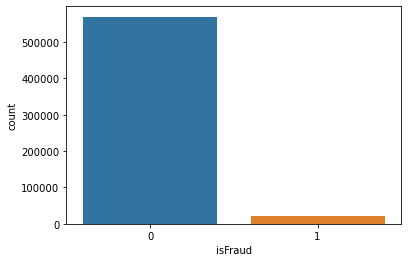

3.5 % are fraud transactions
96.5 % are legitimate transactions


0    569877
1     20663
Name: isFraud, dtype: int64

In [21]:
#checking target variable--(dataset imbalance)

sns.countplot(Data['isFraud'])
plt.show()
print(np.round(Data[Data['isFraud']==1].shape[0]/Data.shape[0]*100,2),'% are fraud transactions')
print(np.round(Data[Data['isFraud']==0].shape[0]/Data.shape[0]*100,2),'% are legitimate transactions')
Data['isFraud'].value_counts()

Most of the transactions in this dataset are non-fraud cases. If we use this dataset as the base for our predictive models and analysis, we might get a lot of errors and our algorithms will probably overfit.Hence, Resampling the dataset is agood option.

lets do the analysis on TransactionAmt distribution

In [22]:
print(pd.concat([Data[Data['isFraud'] == 1]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index(), 
                 Data[Data['isFraud'] == 0]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index()],
                axis=1, keys=['Fraud', "Legitimate"]))

  Fraud                Legitimate               
  index TransactionAmt      index TransactionAmt
0  0.01       6.739453       0.01       9.511875
1  0.10      18.937500       0.10      26.312500
2  0.25      35.031250       0.25      43.968750
3  0.50      75.000000       0.50      68.500000
4  0.75     161.000000       0.75     120.000000
5  0.90     335.000000       0.90     267.100000
6  0.99     994.000000       0.99    1104.000000


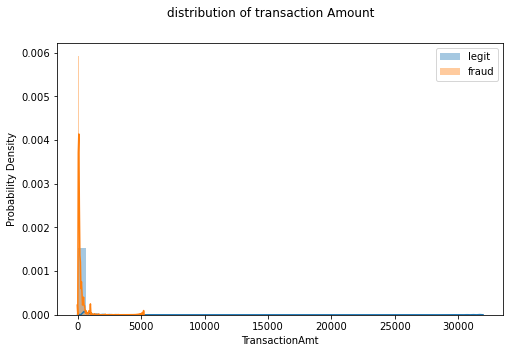

In [23]:
plt.figure(figsize=(8,5))
sns.distplot(Data[Data['isFraud']==0]['TransactionAmt'])
sns.distplot(Data[Data['isFraud']==1]['TransactionAmt'])
# plt.xticks(np.arange(0, 6500, 500))
plt.ylabel('Probability Density')
plt.legend(['legit','fraud'])
plt.suptitle('distribution of transaction Amount ' , fontsize=12)
plt.show()

TransactionAmt distribution is  skewed.we will do log  transformation for better visualization.

In [24]:
#lets create a new feature by taking logvalue of amount
Data['LogAmt'] = np.log(Data['TransactionAmt'])

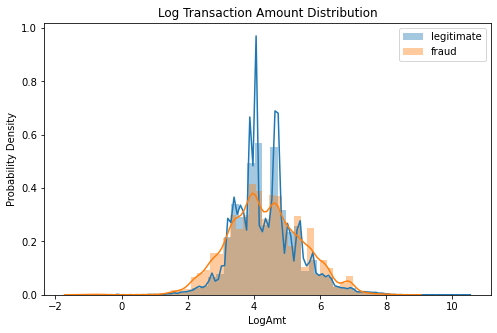

In [25]:
#log plot of TransactionAmt
plt.figure(figsize=(8,5))
sns.distplot(Data[Data['isFraud']==0]['LogAmt'])
sns.distplot(Data[Data['isFraud']==1]['LogAmt'])
# plt.xticks(np.arange(0, 6500, 500))
plt.ylabel('Probability Density')
plt.legend(['legitimate','fraud'])
plt.title('Log Transaction Amount Distribution' , fontsize=12)
plt.show()

 LogTransactionAmt that is larger than 6 and smaller than 3 have higher probability density being fraudulent.

In [26]:
#exploring transactionDT(in seconds)
#lets do some calculations of TransactionDT(timedelta)

period = (Data['TransactionDT'].max() - Data['TransactionDT'].min())/(3600*24)
print('period of data is {:.2f} days'.format(period))

period of data is 182.00 days


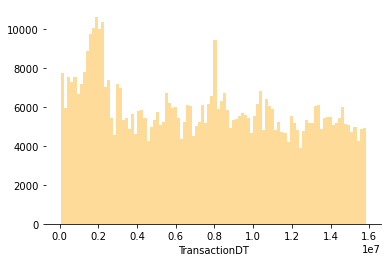

In [27]:
sns.distplot(Data['TransactionDT'],kde=False,bins= 100,color='orange')
sns.despine(left=True)

In [28]:
Data['day'] = (Data['TransactionDT']//(3600*24))%7

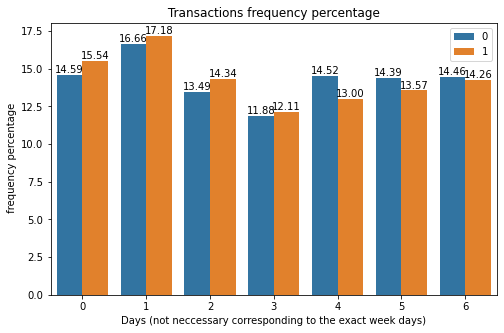

In [29]:
day = Data.groupby('isFraud')['day'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('day')
plt.figure(figsize=(8,5))
barplot = sns.barplot(x="day", y="percentage", hue="isFraud", data=day)
plt.legend()
plt.ylabel(' frequency percentage')
plt.xlabel('Days (not neccessary corresponding to the exact week days)')
plt.title(' Transactions frequency percentage ')
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.show()

In [30]:
Data['Hour'] = (Data['TransactionDT']//(3600))%24

In [31]:
hour = (Data.groupby(['isFraud'])['Hour']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('Hour'))

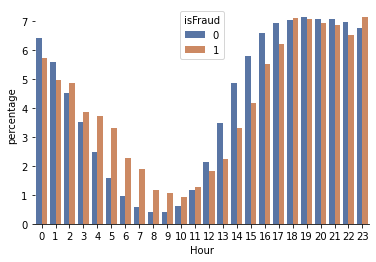

In [32]:
sns.barplot(x="Hour", y="percentage", hue="isFraud",palette="deep", data=hour)
sns.despine(left=True)

Around 2am-10am(time is not exact ) percentage of fraud transaction is higher than legitimate.

In [33]:
def interval_time(Hour):  
    
    if Hour<= 2:
        return "Night(21-2)"
    
    elif Hour<= 7:
        return "Early-Morning(3-7)"
    
    elif Hour<= 11:
        return "Morning(8-11)"
    
    elif Hour<= 16:
        return "Mid-Day(12-16)"
    
    elif Hour<= 20:
        return "Evening(17-20)"
    
    elif Hour <= 24:
        return "Night(21-2)"

In [34]:
Data['interval_time'] = Data['Hour'].apply(interval_time)

In [35]:
int_tim = pd.DataFrame((Data.groupby(['isFraud'])['interval_time']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('interval_time')))

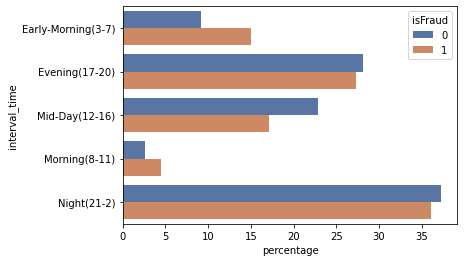

In [36]:
sns.barplot(y="interval_time", x="percentage", hue="isFraud",palette="deep", data=int_tim)

percentage of fraud transaction are more during early morning--morning (3am to 11am)

lets explore column ProductCD(product code)

In [37]:
Data['ProductCD'].value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

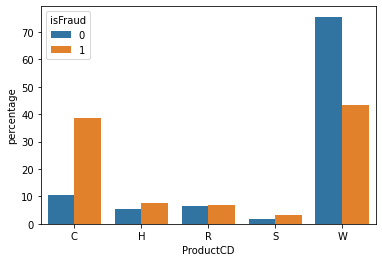

In [38]:
plt.figure(figsize=(6,4))
product= (Data.groupby(['isFraud'])['ProductCD']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('ProductCD'))
sns.barplot(x="ProductCD", y="percentage", hue="isFraud", data=product)

The transaction involving product C is having  high chance to be fraud.In H,R,S also there is a higher fraud percent compared to legitimate percent.Legitimate transaction percent is more for product w.

In [39]:
#lets explore the cards (card1,card2,card3,card4,card5,card6) 
card_list = pd.DataFrame(Data[['card1', 'card2', 'card3', 'card4', 'card5', 'card6']])
total_missing = card_list.isnull().sum().sort_values(ascending = False)
percent_missing = (card_list.isnull().sum()/card_list.isnull().count()*100)
datatype = card_list.dtypes
unique = card_list.nunique()
summary_card = pd.concat([total_missing, percent_missing,datatype,unique], axis=1, keys=['Total_missing', 'Percent_missing','datatype','unique'])
summary_card

,Total_missing,Percent_missing,datatype,unique
card2,8933,1.512683,float16,500
card5,4259,0.721204,float16,119
card4,1577,0.267044,object,4
card6,1571,0.266028,object,4
card3,1565,0.265012,float16,114
card1,0,0.000000,int16,13553


In [40]:
for i in range(1, 7):
    print(Data['card' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

7919     0.025285
9500     0.023981
15885    0.017545
17188    0.017516
15066    0.013454
Name: card1, dtype: float64


321.0    0.082865
111.0    0.076525
555.0    0.071113
490.0    0.064593
583.0    0.036920
Name: card2, dtype: float64


150.0    0.882729
185.0    0.095414
106.0    0.002660
NaN      0.002650
146.0    0.002120
Name: card3, dtype: float64


visa                0.651551
mastercard          0.320414
american express    0.014102
discover            0.011263
NaN                 0.002670
Name: card4, dtype: float64


226.0    0.502161
224.0    0.138031
166.0    0.096759
102.0    0.049285
117.0    0.043928
Name: card5, dtype: float64


debit              0.744976
credit             0.252288
NaN                0.002660
debit or credit    0.000051
charge card        0.000025
Name: card6, dtype: float64




Card 1 and Card 2 has a large distribution of values.

Text(0.5, 1.0, 'Disctribution of Card 1')

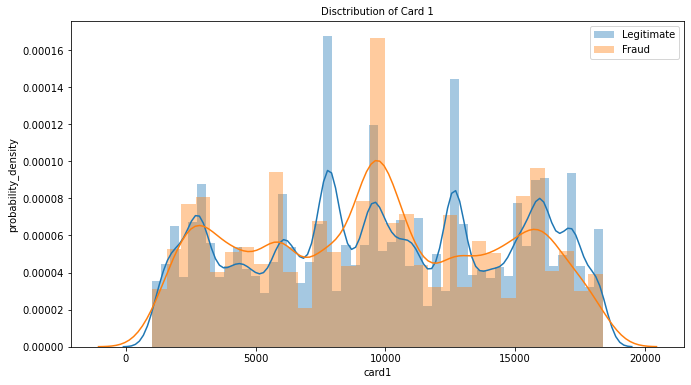

In [41]:
#card1
plt.figure(figsize=(11,6))
sns.distplot(Data[(Data['isFraud']==0) & (~Data['card1'].isnull())]['card1'])
sns.distplot(Data[(Data['isFraud']==1) & (~Data['card1'].isnull())]['card1'])
plt.legend(['Legitimate','Fraud'])
plt.ylabel('probability_density')
plt.title('Disctribution of Card 1' , fontsize=10)

Text(0.5, 1.0, 'Disctribution of Card 2')

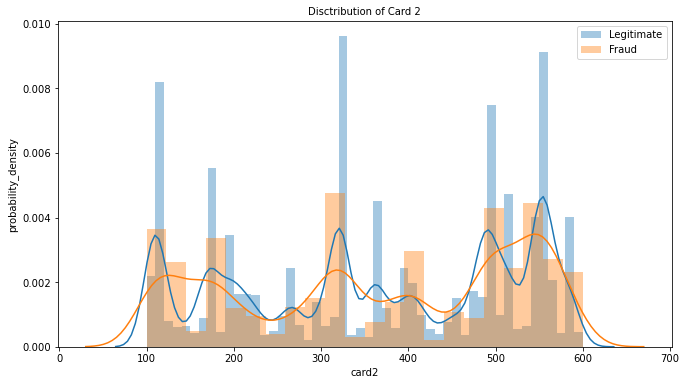

In [42]:
#card2
plt.figure(figsize=(11,6))
sns.distplot(Data[(Data['isFraud']==0) & (~Data['card2'].isnull())]['card2'])
sns.distplot(Data[(Data['isFraud']==1) & (~Data['card2'].isnull())]['card2'])
plt.legend(['Legitimate','Fraud'])
plt.ylabel('probability_density')
plt.title('Disctribution of Card 2' , fontsize=10)

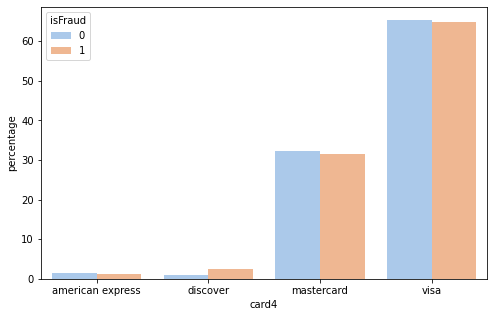

In [43]:
#card4
plt.figure(figsize=(8,5))
card4 = (Data[~Data['card4'].isnull()].groupby(['isFraud'])['card4'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('card4'))
sns.barplot(x="card4", y="percentage", hue="isFraud", data=card4, palette = 'pastel')
plt.show()

In [44]:
#replacing missing values with mode
Data.card4.fillna("visa", inplace=True)

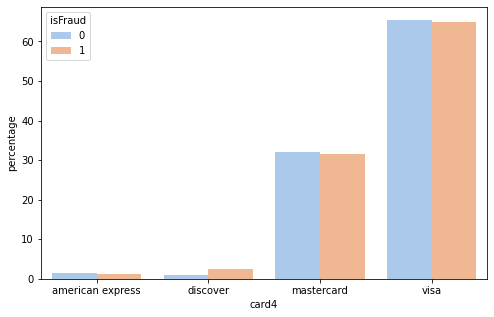

In [45]:
#plotting after replacement
plt.figure(figsize=(8,5))
card4 = (Data[~Data['card4'].isnull()].groupby(['isFraud'])['card4'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('card4'))
sns.barplot(x="card4", y="percentage", hue="isFraud", data=card4, palette = 'pastel')
plt.show()

Visa card is having most transactions.most fraudulent transaction happened in visa card and then master card.

Text(0.5, 1.0, 'Disctribution of Card 2')

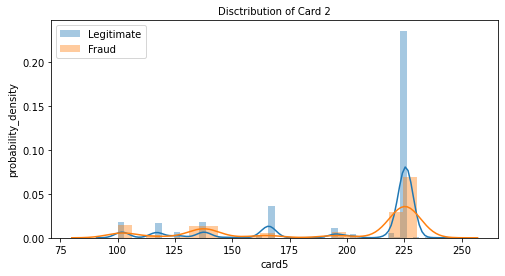

In [46]:
#card5
plt.figure(figsize=(8,4))
sns.distplot(Data[(Data['isFraud']==0) & (~Data['card5'].isnull())]['card5'])
sns.distplot(Data[(Data['isFraud']==1) & (~Data['card5'].isnull())]['card5'])
plt.legend(['Legitimate','Fraud'])
plt.ylabel('probability_density')
plt.title('Disctribution of Card 2' , fontsize=10)

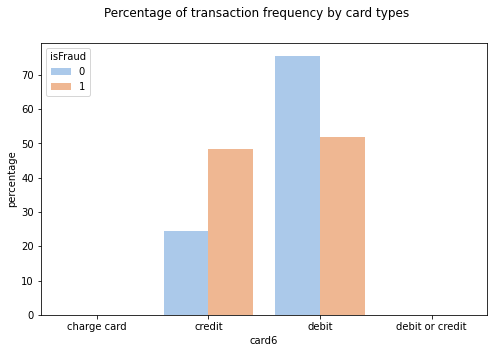

In [47]:
# card6
plt.figure(figsize=(8,5))
card6 = (Data[~Data['card6'].isnull()].groupby(['isFraud'])['card6'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('card6'))
sns.barplot(x="card6", y="percentage", hue="isFraud", data=card6, palette = 'pastel')
plt.suptitle('Percentage of transaction frequency by card types', fontsize=12)
plt.show()

credit card is having  higher percentage of fraud rate. Debit or credit and charge card are almost 0% in the dataset.

In [48]:
##replace debit or credit and charge card to debit(replacing rare values with mode)

Data.loc[Data['card6'].isin(['debit or credit', 'charge card']),'card6'] = 'debit'
Data.card6.fillna("debit", inplace=True)

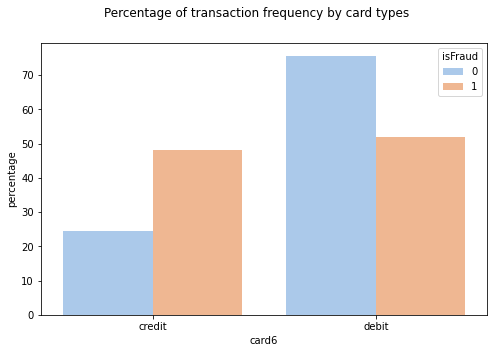

In [49]:
#plotting after replacement
plt.figure(figsize=(8,5))
card6 = (Data[~Data['card6'].isnull()].groupby(['isFraud'])['card6'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('card6'))
sns.barplot(x="card6", y="percentage", hue="isFraud", data=card6, palette = 'pastel')
plt.suptitle('Percentage of transaction frequency by card types', fontsize=12)
plt.show()

In [50]:
#lets do log transformation of all numerical cards
Data['Logcard1'] = np.log(Data['card1'])
Data['Logcard2'] = np.log(Data['card2'])
Data['Logcard3'] = np.log(Data['card3'])
Data['Logcard5'] = np.log(Data['card5'])

In [51]:
#adress-addr1,addr2
##addr1-purchaser's billing region(zipcode),addr2-purchaser's billing country.

In [52]:
address = pd.DataFrame(Data[['addr1', 'addr2']])
total_missing = address.isnull().sum().sort_values(ascending = False)
percent_missing = (address.isnull().sum()/address.isnull().count()*100)
datatype = address.dtypes
unique = address.nunique()
summary_addr = pd.concat([total_missing, percent_missing,datatype,unique], axis=1, keys=['Total_missing', 'Percent_missing','datatype','unique'])
summary_addr

,Total_missing,Percent_missing,datatype,unique
addr2,65706,11.126427,float16,74
addr1,65706,11.126427,float16,332


In [53]:
Data['addr1'].value_counts()

299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287
         ...  
462.0        1
128.0        1
481.0        1
120.0        1
340.0        1
Name: addr1, Length: 332, dtype: int64

In [54]:
Data.addr1.unique()

array([315., 325., 330., 476., 420., 272., 126., 337., 204.,  nan, 226.,
       170., 184., 264., 299., 441., 472., 251., 469., 191., 485., 122.,
       220., 205., 387., 181., 231., 436., 327., 343., 123., 502., 269.,
       158., 433., 143., 225., 492., 177., 512., 310., 308., 418., 494.,
       253., 428., 203., 110., 444., 498., 194., 536., 384., 324., 295.,
       448., 157., 171., 224., 491., 274., 432., 459., 106., 296., 254.,
       452., 347., 335., 305., 161., 221., 154., 130., 465., 451., 331.,
       511., 486., 312., 242., 131., 508., 332., 283., 216., 431., 391.,
       333., 496., 304., 167., 261., 399., 164., 142., 393., 258., 375.,
       483., 404., 482., 148., 218., 127., 403., 374., 477., 478., 241.,
       504., 453., 535., 100., 239., 152., 500., 356., 198., 162., 244.,
       520., 531., 401., 427., 352., 540., 456., 371., 409., 529., 505.,
       503., 346., 359., 499., 298., 190., 454., 172., 145., 493., 119.,
       521., 270., 395., 366., 348., 313., 338., 13

In [55]:
Data['addr2'].value_counts()

87.0    520481
60.0      3084
96.0       638
32.0        91
65.0        82
         ...  
55.0         1
79.0         1
49.0         1
50.0         1
70.0         1
Name: addr2, Length: 74, dtype: int64

In [56]:
Data.addr2.unique()

array([ 87.,  nan,  96.,  35.,  60.,  98.,  43.,  65.,  32.,  13.,  31.,
       101.,  24.,  16.,  15.,  19.,  71.,  59., 102.,  44.,  26.,  69.,
        47.,  78.,  88.,  66.,  72.,  22.,  57.,  25.,  17.,  30.,  29.,
        21.,  14.,  49.,  83.,  75.,  34.,  86.,  48.,  68.,  23.,  70.,
        62.,  54.,  50.,  52.,  39.,  76.,  10.,  73.,  97.,  63.,  27.,
        28.,  38.,  74.,  77.,  92.,  79.,  84.,  82.,  40.,  36.,  46.,
        18.,  20.,  89.,  61.,  94., 100.,  55.,  51.,  93.],
      dtype=float16)

In [57]:
# replacing rear values with mode in addr1 and addr2.
Data.loc[Data.addr1.isin(Data.addr1.value_counts()[Data.addr1.value_counts() <= 5000 ].index), 'addr1'] = "299.0"

Data.loc[Data.addr2.isin(Data.addr2.value_counts()[Data.addr2.value_counts() <= 50 ].index), 'addr2'] = "87.0"

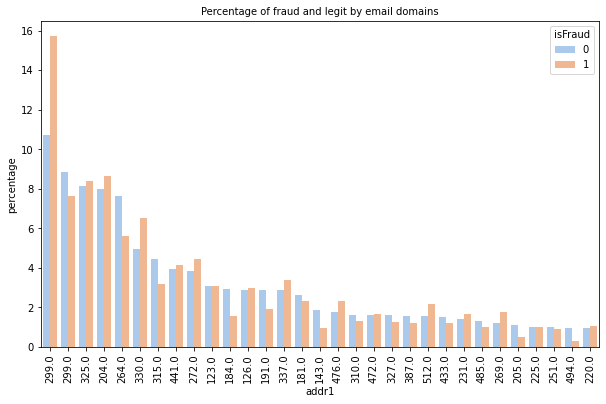

In [58]:
plt.figure(figsize=(10,6))
addr1 = (Data[~Data['addr1'].isnull()].groupby(['isFraud'])['addr1']\
         .value_counts(normalize=True).rename('percentage')\
         .mul(100).reset_index())
sns.barplot(x="addr1", y="percentage", hue="isFraud", data=addr1, palette = 'pastel')
plt.xticks(rotation=90)
plt.title('Percentage of fraud and legit by email domains', fontsize=10)
plt.show()

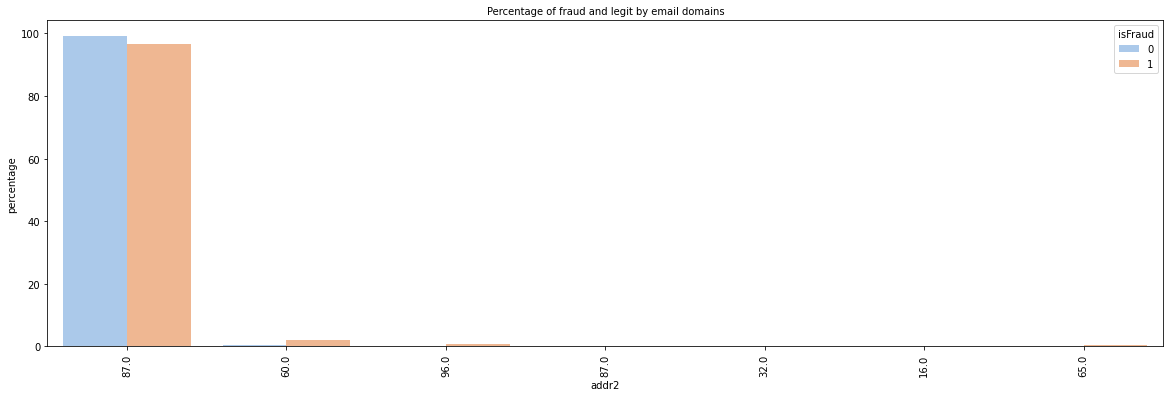

In [59]:
plt.figure(figsize=(20,6))
addr1 = (Data[~Data['addr2'].isnull()].groupby(['isFraud'])['addr2']\
         .value_counts(normalize=True).rename('percentage')\
         .mul(100).reset_index())
sns.barplot(x="addr2", y="percentage", hue="isFraud", data=addr1, palette = 'pastel')
plt.xticks(rotation=90)
plt.title('Percentage of fraud and legit by email domains', fontsize=10)
plt.show()

Highest fraud transactions are happening in billing region 299 and billing country 87.

In [60]:
#distance-dist1
distance = pd.DataFrame(Data[['dist1']])
total_missing = distance.isnull().sum().sort_values(ascending = False)
percent_missing = (distance.isnull().sum()/distance.isnull().count()*100)
datatype = distance.dtypes
unique = distance.nunique()
summary_addr = pd.concat([total_missing, percent_missing,datatype,unique], axis=1, keys=['Total_missing', 'Percent_missing','datatype','unique'])
summary_addr

,Total_missing,Percent_missing,datatype,unique
dist1,352271,59.652352,float16,2412


In [61]:
print("distance: ")
print(Data[['dist1' ]].quantile([0.01, .025, .1, .25, .5, .75, .975, .99]))

distance: 
        dist1
0.010     0.0
0.025     0.0
0.100     1.0
0.250     3.0
0.500     8.0
0.750    24.0
0.975  1284.0
0.990  2040.0


Text(0.5, 1.0, 'dist1')

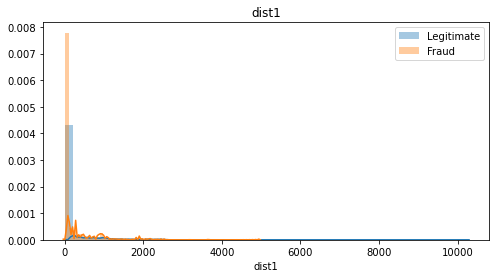

In [62]:
#dist1
plt.figure(figsize=(8,4))
sns.distplot(Data[(Data['isFraud']==0) & (~Data['dist1'].isnull())]['dist1'])
sns.distplot(Data[(Data['isFraud']==1) & (~Data['dist1'].isnull())]['dist1'])
plt.legend(['Legitimate','Fraud'])
plt.title('dist1')

In [63]:
## replacing missing values with mean
Data['dist1'] = Data['dist1'].fillna(-100)
Data['dist1'] = Data['dist1'].fillna(-100)

In [64]:
#Analysis of email domains-(P_emaildomain,R_emaildomain)
Data['P_emaildomain'].value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
windstream.net         305
roadrunner.com         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
twc.com                230
n

In [65]:
#R_emaildomain
Data['R_emaildomain'].value_counts()

gmail.com           57147
hotmail.com         27509
anonymous.com       20529
yahoo.com           11842
aol.com              3701
outlook.com          2507
comcast.net          1812
yahoo.com.mx         1508
icloud.com           1398
msn.com               852
live.com              762
live.com.mx           754
verizon.net           620
me.com                556
sbcglobal.net         552
cox.net               459
outlook.es            433
att.net               430
bellsouth.net         422
hotmail.fr            293
hotmail.es            292
web.de                237
mac.com               218
prodigy.net.mx        207
ymail.com             207
optonline.net         187
gmx.de                147
yahoo.fr              137
charter.net           127
mail.com              122
hotmail.co.uk         105
gmail                  95
earthlink.net          79
yahoo.de               75
rocketmail.com         69
embarqmail.com         68
scranton.edu           63
yahoo.es               57
live.fr     

In [66]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum',
          'scranton.edu': 'other', 'netzero.net': 'other',
          'optonline.net': 'other', 'comcast.net': 'other', 
          'cfl.rr.com': 'other', 'sc.rr.com': 'other',
          'suddenlink.net': 'other', 'windstream.net': 'other',
          'gmx.de': 'other', 'earthlink.net': 'other', 
          'servicios-ta.com': 'other', 'bellsouth.net': 'other', 
          'web.de': 'other', 'mail.com': 'other',
          'cableone.net': 'other', 'roadrunner.com': 'other', 
          'protonmail.com': 'other', 'anonymous.com': 'other',
          'juno.com': 'other', 'ptd.net': 'other',
          'netzero.com': 'other', 'cox.net': 'other', 
          'hotmail.co.uk': 'microsoft', 
          'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 
          'live.com': 'microsoft', 'aim.com': 'aol',
          'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 
          'hotmail.com': 'microsoft',  
          'hotmail.fr': 'microsoft',
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 
          'yahoo.de': 'yahoo', 
          'live.fr': 'microsoft', 'verizon.net': 'yahoo', 
          'msn.com': 'microsoft', 'q.com': 'centurylink',
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 
           'rocketmail.com': 'yahoo', 
          'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 
          'embarqmail.com': 'centurylink', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo',
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft',
           'aol.com': 'aol', 'icloud.com': 'apple'}



In [67]:
for c in ['P_emaildomain', 'R_emaildomain']:
    Data[c + '_bin'] = Data[c].map(emails)
    Data[c + '_suffix'] = Data[c].map(lambda x: str(x).split('.')[-1])
    

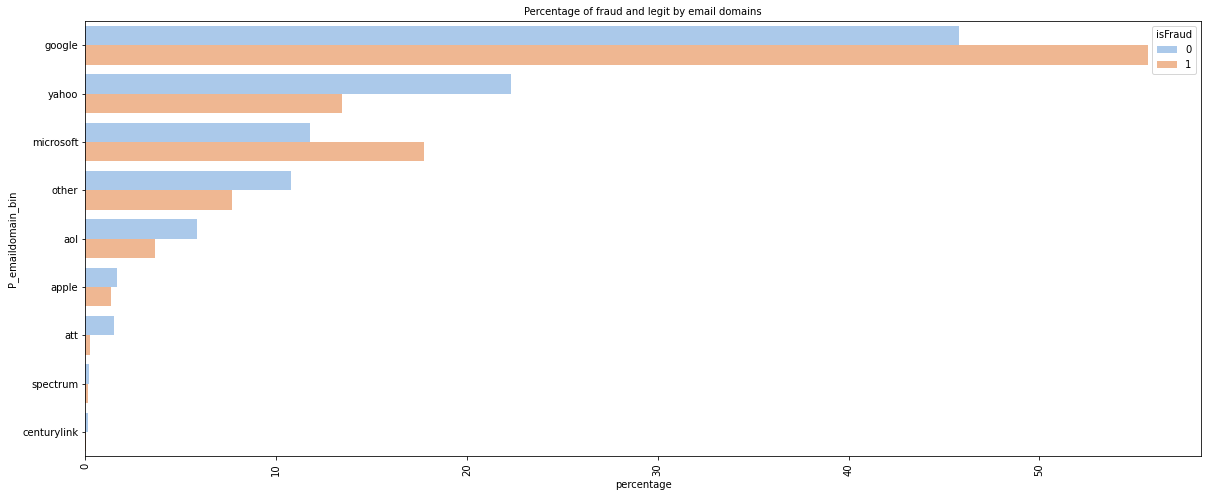

In [68]:
plt.figure(figsize=(20,8))
train_P_email = (Data[~Data['P_emaildomain_bin'].isnull()].groupby(['isFraud'])['P_emaildomain_bin'].value_counts(normalize=True).rename('percentage').mul(100).reset_index())
sns.barplot(y="P_emaildomain_bin", x="percentage", hue="isFraud", data=train_P_email, palette = 'pastel')
plt.xticks(rotation=90)
plt.title('Percentage of fraud and legit by email domains', fontsize=10)
plt.show()

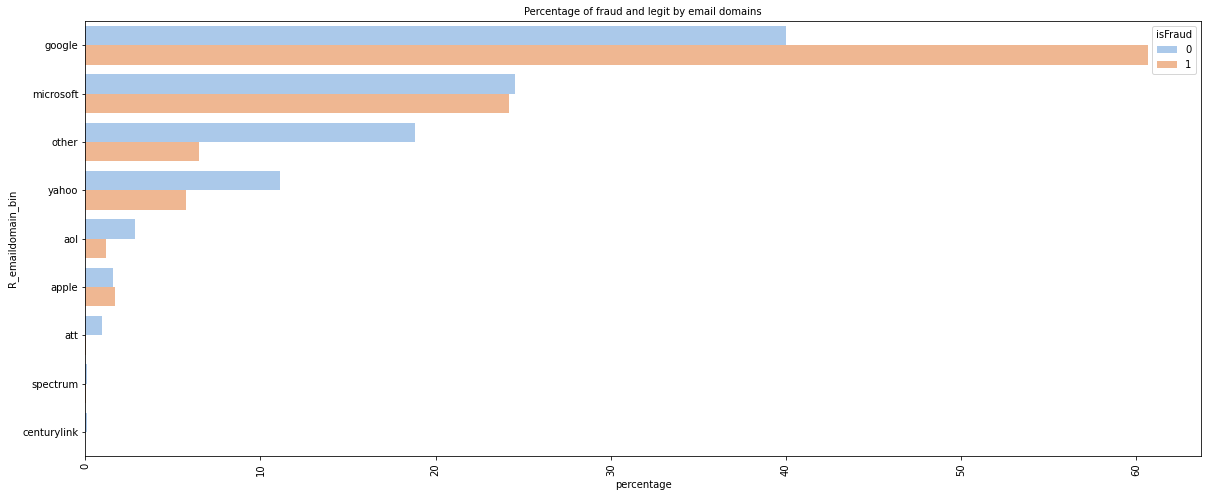

In [69]:
plt.figure(figsize=(20,8))
R_email = (Data[~Data['R_emaildomain_bin'].isnull()].groupby(['isFraud'])['R_emaildomain_bin'].value_counts(normalize=True).rename('percentage').mul(100).reset_index())
sns.barplot(y="R_emaildomain_bin", x="percentage", hue="isFraud", data=R_email, palette = 'pastel')
plt.xticks(rotation=90)
plt.title('Percentage of fraud and legit by email domains', fontsize=10)
plt.show()

Google is the most frequent email domain in both columns.It is the most commonly used email domain by frauds.

M1-M9(names on cards and adresses etc)

In [70]:
for i in range(1, 10):
    print(Data['M' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

T      0.540886
NaN    0.459071
F      0.000042
Name: M1, dtype: float64


T      0.483402
NaN    0.459071
F      0.057527
Name: M2, dtype: float64


NaN    0.459071
T      0.426273
F      0.114656
Name: M3, dtype: float64


NaN    0.476588
M0     0.332585
M2     0.101373
M1     0.089454
Name: M4, dtype: float64


NaN    0.593494
F      0.224356
T      0.182150
Name: M5, dtype: float64


F      0.385843
T      0.327368
NaN    0.286788
Name: M6, dtype: float64


NaN    0.586353
F      0.357933
T      0.055713
Name: M7, dtype: float64


NaN    0.586331
F      0.262897
T      0.150772
Name: M8, dtype: float64


NaN    0.586331
T      0.348251
F      0.065418
Name: M9, dtype: float64




In [71]:
#There are a lot of missing values in M1-M9. Replacing missing values with 'Miss'
m_feat = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
for col in m_feat:
    Data[col].fillna('Miss', inplace=True)

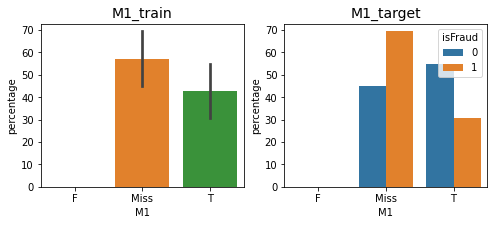

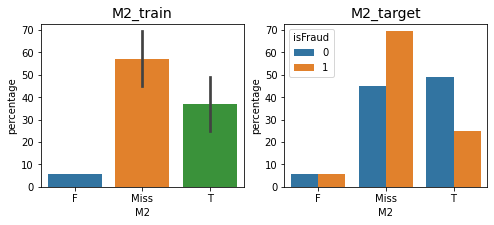

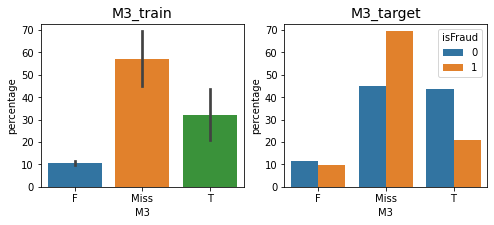

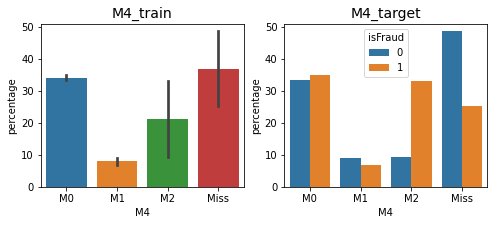

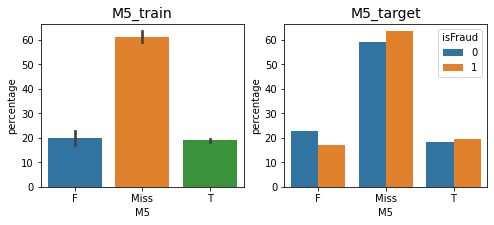

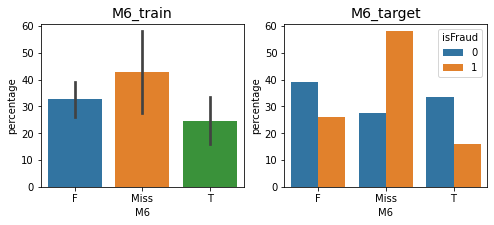

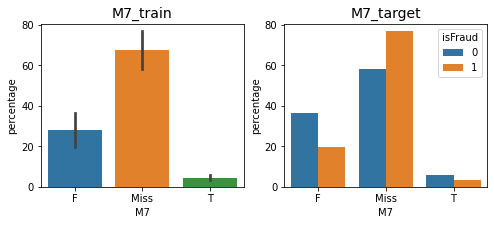

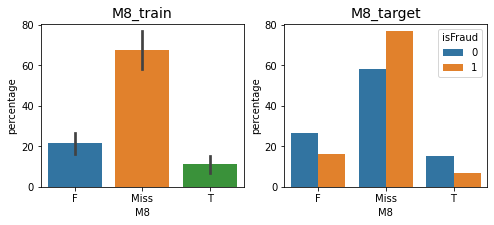

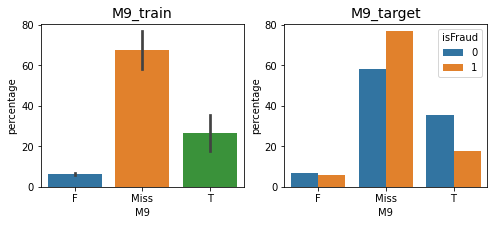

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
m1_grouped = (Data.groupby(['isFraud'])['M1']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M1'))
sns.barplot(x="M1", ax=ax[0],y="percentage", data=m1_grouped)
ax[0].set_title('M1_train', fontsize=14)
sns.barplot(x="M1",ax=ax[1], y="percentage", hue="isFraud", data=m1_grouped)
ax[1].set_title('M1_target', fontsize=14)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,3))
m2_grouped = (Data.groupby(['isFraud'])['M2']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M2'))
sns.barplot(x="M2", ax=ax[0],y="percentage", data=m2_grouped)
ax[0].set_title('M2_train', fontsize=14)
sns.barplot(x="M2",ax=ax[1], y="percentage", hue="isFraud", data=m2_grouped)
ax[1].set_title('M2_target', fontsize=14)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,3))
m3_grouped = (Data.groupby(['isFraud'])['M3']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M3'))
sns.barplot(x="M3", ax=ax[0],y="percentage", data=m3_grouped)
ax[0].set_title('M3_train', fontsize=14)
sns.barplot(x="M3",ax=ax[1], y="percentage", hue="isFraud", data=m3_grouped)
ax[1].set_title('M3_target', fontsize=14)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,3))
m4_grouped = (Data.groupby(['isFraud'])['M4']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M4'))
sns.barplot(x="M4", ax=ax[0],y="percentage", data=m4_grouped)
ax[0].set_title('M4_train', fontsize=14)
sns.barplot(x="M4",ax=ax[1], y="percentage", hue="isFraud", data=m4_grouped)
ax[1].set_title('M4_target', fontsize=14)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,3))
m5_grouped = (Data.groupby(['isFraud'])['M5']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M5'))
sns.barplot(x="M5", ax=ax[0],y="percentage", data=m5_grouped)
ax[0].set_title('M5_train', fontsize=14)
sns.barplot(x="M5",ax=ax[1], y="percentage", hue="isFraud", data=m5_grouped)
ax[1].set_title('M5_target', fontsize=14)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,3))
m6_grouped = (Data.groupby(['isFraud'])['M6']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M6'))
sns.barplot(x="M6", ax=ax[0],y="percentage", data=m6_grouped)
ax[0].set_title('M6_train', fontsize=14)
sns.barplot(x="M6",ax=ax[1], y="percentage", hue="isFraud", data=m6_grouped)
ax[1].set_title('M6_target', fontsize=14)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,3))
m7_grouped = (Data.groupby(['isFraud'])['M7']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M7'))
sns.barplot(x="M7", ax=ax[0],y="percentage", data=m7_grouped)
ax[0].set_title('M7_train', fontsize=14)
sns.barplot(x="M7",ax=ax[1], y="percentage", hue="isFraud", data=m7_grouped)
ax[1].set_title('M7_target', fontsize=14)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,3))
m8_grouped = (Data.groupby(['isFraud'])['M8']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M8'))
sns.barplot(x="M8", ax=ax[0],y="percentage", data=m8_grouped)
ax[0].set_title('M8_train', fontsize=14)
sns.barplot(x="M8",ax=ax[1], y="percentage", hue="isFraud", data=m8_grouped)
ax[1].set_title('M8_target', fontsize=14)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,3))
m9_grouped = (Data.groupby(['isFraud'])['M9']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M9'))
sns.barplot(x="M9", ax=ax[0],y="percentage", data=m9_grouped)
ax[0].set_title('M9_train', fontsize=14)
sns.barplot(x="M9",ax=ax[1], y="percentage", hue="isFraud", data=m9_grouped)
ax[1].set_title('M9_target', fontsize=14)
plt.show()

ID(ID1-ID38)

In [73]:
# EXPLORING ID COLUMNS
###All columns have missing values above 75%

for i in range(1, 10):
    print(Data['id_0' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')
    
for i in range(10, 39):
    print(Data['id_' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

 NaN     0.755761
-5.0     0.139144
 0.0     0.033114
-10.0    0.019062
-20.0    0.018984
Name: id_01, dtype: float64


NaN       0.761452
1102.0    0.000019
696.0     0.000017
1116.0    0.000015
1120.0    0.000015
Name: id_02, dtype: float64


NaN    0.887689
0.0    0.108211
1.0    0.001461
3.0    0.001131
2.0    0.000713
Name: id_03, dtype: float64


 NaN    0.887689
 0.0    0.111320
-5.0    0.000224
-6.0    0.000166
-8.0    0.000108
Name: id_04, dtype: float64


NaN    0.768238
0.0    0.157048
1.0    0.014043
2.0    0.008360
3.0    0.006526
Name: id_05, dtype: float64


 NaN    0.768238
 0.0    0.154647
-1.0    0.007937
-5.0    0.006518
-6.0    0.005515
Name: id_06, dtype: float64


NaN     0.991271
0.0     0.000693
16.0    0.000415
14.0    0.000386
12.0    0.000352
Name: id_07, dtype: float64


 NaN      0.991271
-100.0    0.000847
 0.0      0.000442
-34.0     0.000435
-33.0     0.000354
Name: id_08, dtype: float64


NaN    0.873123
0.0    0.119176
1.0    0.002736
3.0    0.001636
2

In [74]:
#All the id columns having missing values 75% and above.
#lets take a closer look(id_30,id_31-- contains versions and id_33 contains resolution)
Data['id_30'].value_counts().head()  

Windows 10     21155
Windows 7      13110
iOS 11.2.1      3722
iOS 11.1.2      3699
Android 7.0     2871
Name: id_30, dtype: int64

In [75]:
Data['id_31'].value_counts().head()  

chrome 63.0              22000
mobile safari 11.0       13423
mobile safari generic    11474
ie 11.0 for desktop       9030
safari generic            8195
Name: id_31, dtype: int64

In [76]:
Data['id_33'].value_counts().head()  

1920x1080    16874
1366x768      8605
1334x750      6447
2208x1242     4900
1440x900      4384
Name: id_33, dtype: int64

id_30,id_31 contains versions, id_33 contains resolution we will split these colums and will replace missing values.

In [77]:
Data['OS_id_30'] = Data['id_30'].str.split(' ', expand=True)[0]
Data['version_id_30'] = Data['id_30'].str.split(' ',expand=True)[1] 
Data['OS_id_30'].fillna('None', inplace=True) 
Data['version_id_30'].fillna('None', inplace=True) 
Data.drop('id_30', axis=1, inplace=True)

In [78]:
Data['browser_id_31'] = Data['id_31'].str.split(' ', expand=True)[0]
Data['version_id_31'] = Data['id_31'].str.split(' ', expand=True)[1] 
Data['browser_id_31'].fillna('None', inplace=True)
Data['version_id_31'].fillna('None', inplace=True) 
Data.drop('id_31', axis=1, inplace=True)

In [79]:
Data['screen_width'] = Data['id_33'].str.split('x', expand=True)[0] 
Data['screen_height'] = Data['id_33'].str.split('x', expand=True)[1]
Data['screen_width'].fillna(-1, inplace=True)
Data['screen_height'].fillna(-1, inplace=True)
Data.drop('id_33', axis=1, inplace=True)

In [80]:
Data['id_34'] = Data['id_34'].str.split(':', expand=True)[1] 
Data['id_34'].fillna(-2, inplace=True)
Data['id_23'] = Data['id_23'].str.split(':', expand=True)[1] 
Data['id_23'].fillna('None', inplace=True) 

In [81]:
#replacing missing values in numerical id columns with an arbitary value
id_num = ['id_13', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26','id_32']

for col in id_num:
    Data[col].fillna(Data[col].min() - 100, inplace=True)

In [82]:
#replacing missing values in categorical id columns  with label  'none'.
to_fill_none = ['id_12','id_15', 'id_16', 'id_23','id_27', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38']
for col in to_fill_none: 
    Data[col].fillna('None', inplace=True)

In [83]:
ID_features = Data[['id_01','id_02','id_03','id_04','id_05','id_06','id_09','id_10','id_11',
             'id_13','id_14','id_17','id_19','id_20','id_28','id_29','id_32',
             'id_34','id_35','id_36','id_37','id_38','isFraud']]

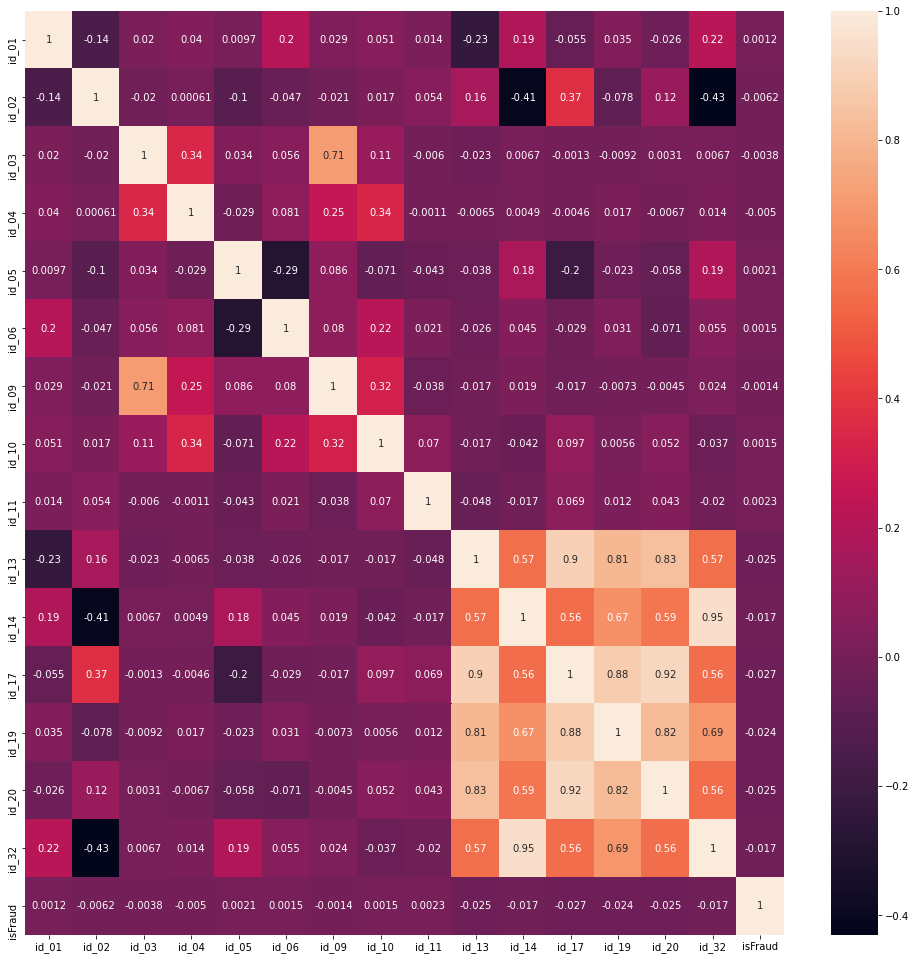

In [84]:
#Checking correlation between numerical ID columns
plt.figure(figsize=(17,17))
sns.heatmap(ID_features.corr(),annot=True)

some of the ID columns are highly correlated

Device Type

In [85]:
Data['DeviceType'].value_counts()

desktop    85165
mobile     55645
Name: DeviceType, dtype: int64

In [86]:
Data['DeviceType'].fillna('None', inplace=True)

Text(0.5, 1.0, 'Devicetype')

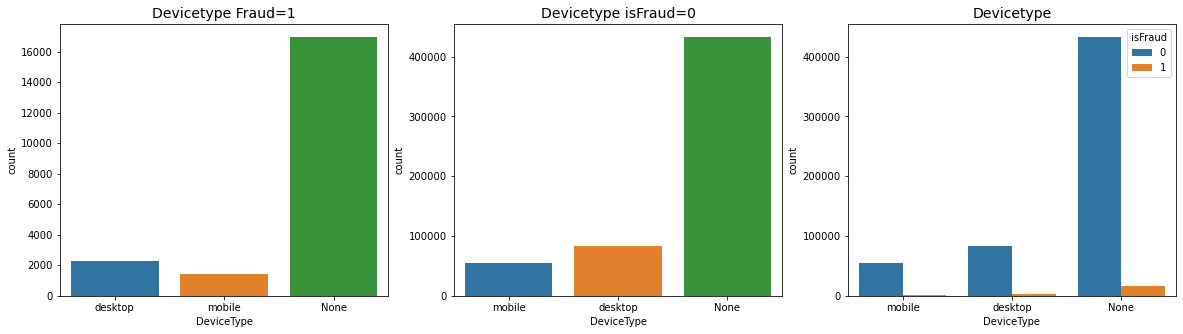

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
sns.countplot(x="DeviceType", ax=ax[0], data=Data.loc[Data['isFraud'] == 1])
ax[0].set_title('Devicetype Fraud=1', fontsize=14)
sns.countplot(x="DeviceType", ax=ax[1], data=Data.loc[Data['isFraud'] == 0])
ax[1].set_title('Devicetype isFraud=0', fontsize=14)
sns.countplot(x="DeviceType",ax=ax[2], hue = "isFraud", data=Data)
ax[2].set_title('Devicetype', fontsize=14)

Fraud transactions are more for desktop device type.

In [88]:
#DeviceInfo--contains device  name and versions.
Data['DeviceInfo'].value_counts().head(10)

Windows                  47722
iOS Device               19782
MacOS                    12573
Trident/7.0               7440
rv:11.0                   1901
rv:57.0                    962
SM-J700M Build/MMB29K      549
SM-G610M Build/MMB29K      461
SM-G531H Build/LMY48B      410
rv:59.0                    362
Name: DeviceInfo, dtype: int64

In [89]:
Data.DeviceInfo.unique()

array(['SAMSUNG SM-G892A Build/NRD90M', 'iOS Device', 'Windows', ...,
       'LDN-LX3 Build/HUAWEILDN-LX3', 'Z955A', 'LG-E975'], dtype=object)

Device_Info contains versions.Hence splitting  that column into 2 and will doing missing value imputation.

In [90]:
Data['device_name'] = Data['DeviceInfo'].str.split('/', expand=True)[0] 
Data['device_version'] = Data['DeviceInfo'].str.split('/', expand=True)[1]

Data.drop('DeviceInfo', axis=1, inplace=True)

Data['device_name'].fillna('None', inplace=True) 
Data['device_version'].fillna('None', inplace=True)

In [91]:
Data.loc[Data['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung' 
Data.loc[Data['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
Data.loc[Data['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung' 
Data.loc[Data['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
Data.loc[Data['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola' 
Data.loc[Data['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola' 
Data.loc[Data['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
Data.loc[Data['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV' 
Data.loc[Data['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei' 
Data.loc[Data['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
Data.loc[Data['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei' 
Data.loc[Data['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE' 
Data.loc[Data['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE' 
Data.loc[Data['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux' 
Data.loc[Data['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony' 
Data.loc[Data['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC' 
Data.loc[Data['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

In [92]:
#Replacing rear values with arbitary value -others
Data.loc[Data.device_name.isin(Data.device_name.value_counts()
        [Data.device_name.value_counts() < 200].index),
          'device_name'] = "Others"

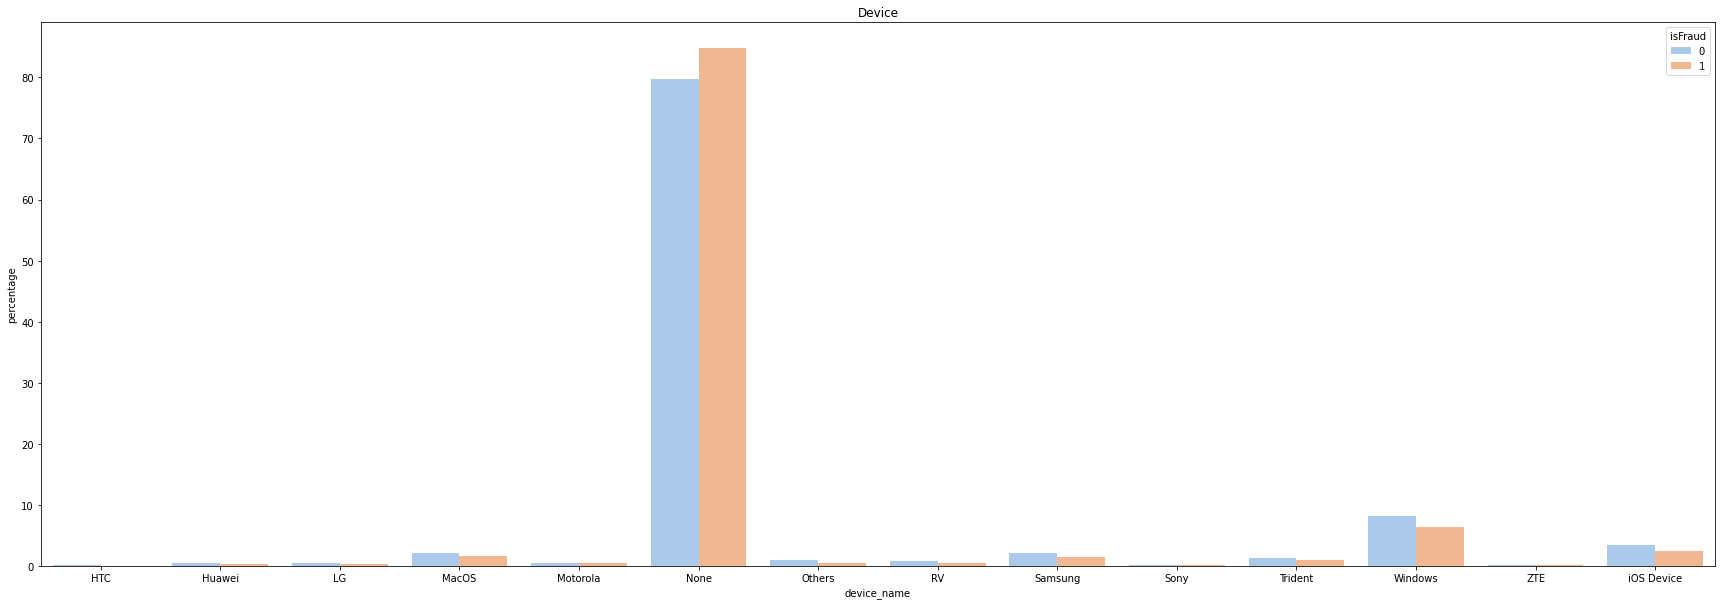

In [93]:
plt.figure(figsize=(30,10))
DeviceCorp = (Data[~Data['device_name'].isnull()].groupby(['isFraud'])['device_name'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('device_name'))
sns.barplot(x="device_name", y="percentage", hue="isFraud", data=DeviceCorp, palette = 'pastel')
plt.title('Device')
plt.show()

In [94]:
#Dfeatures
for i in range(1, 10):
    print(Data['D' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')
for i in range(10, 16):
    print(Data['D' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')    
    

0.0    0.474362
1.0    0.014621
2.0    0.008414
3.0    0.006696
4.0    0.006045
Name: D1, dtype: float64


NaN    0.475492
0.0    0.025610
1.0    0.011268
2.0    0.007542
3.0    0.006227
Name: D2, dtype: float64


NaN    0.445149
0.0    0.123775
1.0    0.035998
2.0    0.023350
7.0    0.022556
Name: D3, dtype: float64


NaN    0.286047
0.0    0.282066
1.0    0.009000
2.0    0.005732
3.0    0.004355
Name: D4, dtype: float64


NaN    0.524674
0.0    0.110707
1.0    0.025878
2.0    0.017347
7.0    0.016483
Name: D5, dtype: float64


NaN      0.876068
0.0      0.077526
1.0      0.002689
256.0    0.001516
2.0      0.001448
Name: D6, dtype: float64


NaN    0.934099
0.0    0.035789
1.0    0.002908
2.0    0.001690
3.0    0.001339
Name: D7, dtype: float64


NaN         0.873123
0.791504    0.002288
0.833496    0.002247
0.875000    0.002208
0.958496    0.002201
Name: D8, dtype: float64


NaN         0.873123
0.791504    0.009124
0.833496    0.008929
0.750000    0.008716
0.708496    0.008690
Name

In [95]:
D_features = Data[['D1','D2','D3','D4','D5','D6','D7','D8'
                          ,'D9','D10','D11','D12','D13','D14','D15','isFraud']]

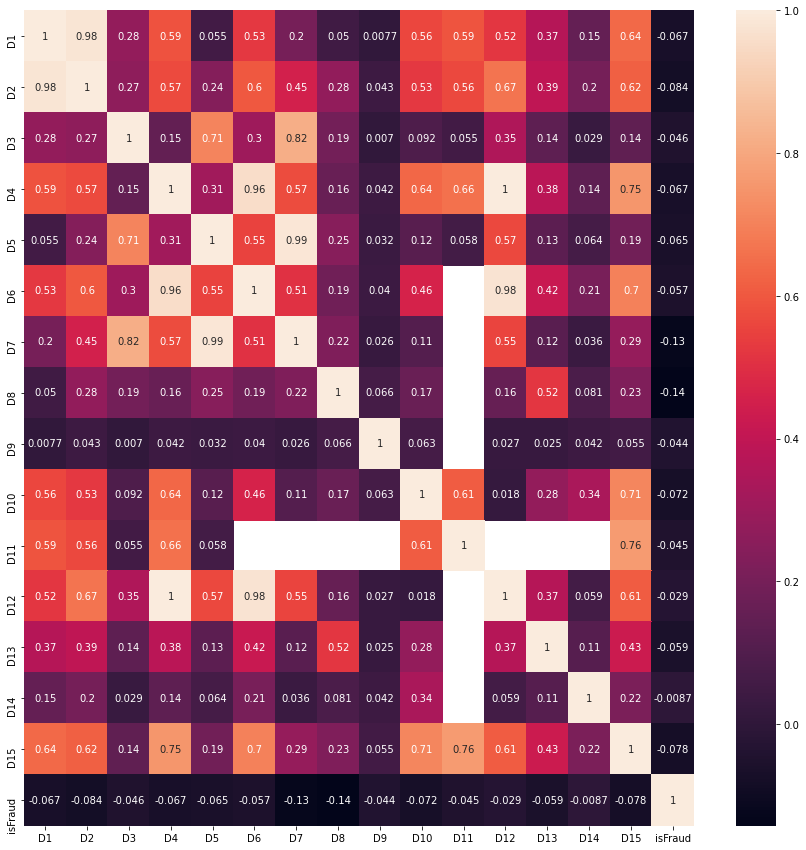

In [96]:
#checking correlation between D features
plt.figure(figsize=(15,15))
sns.heatmap(D_features.corr(),annot=True)

In [97]:
#C features
for i in range(1, 15):
    print(Data['C' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

1.0    0.536443
2.0    0.177924
3.0    0.086895
4.0    0.048845
5.0    0.030348
Name: C1, dtype: float64


1.0    0.535545
2.0    0.176022
3.0    0.087666
4.0    0.047839
5.0    0.028738
Name: C2, dtype: float64


0.0    0.995887
1.0    0.003619
2.0    0.000305
3.0    0.000098
4.0    0.000012
Name: C3, dtype: float64


0.0    0.765203
1.0    0.189347
2.0    0.022004
3.0    0.008380
4.0    0.003221
Name: C4, dtype: float64


0.0    0.630669
1.0    0.208086
2.0    0.058888
3.0    0.022334
4.0    0.011562
Name: C5, dtype: float64


1.0    0.578372
2.0    0.145804
0.0    0.083087
3.0    0.060098
4.0    0.030150
Name: C6, dtype: float64


0.0    0.885871
1.0    0.087997
2.0    0.012385
3.0    0.003443
4.0    0.001878
Name: C7, dtype: float64


0.0    0.758064
1.0    0.177793
2.0    0.026970
3.0    0.009302
4.0    0.004770
Name: C8, dtype: float64


1.0    0.387676
0.0    0.311232
2.0    0.131793
3.0    0.055043
4.0    0.027426
Name: C9, dtype: float64


0.0    0.767843
1.0    0.169728
2.0  

In [98]:
C_features = Data[['C1','C2','C3','C4','C5','C6','C7','C8',
                         'C9','C10','C11','C12','C13','C14','isFraud']]

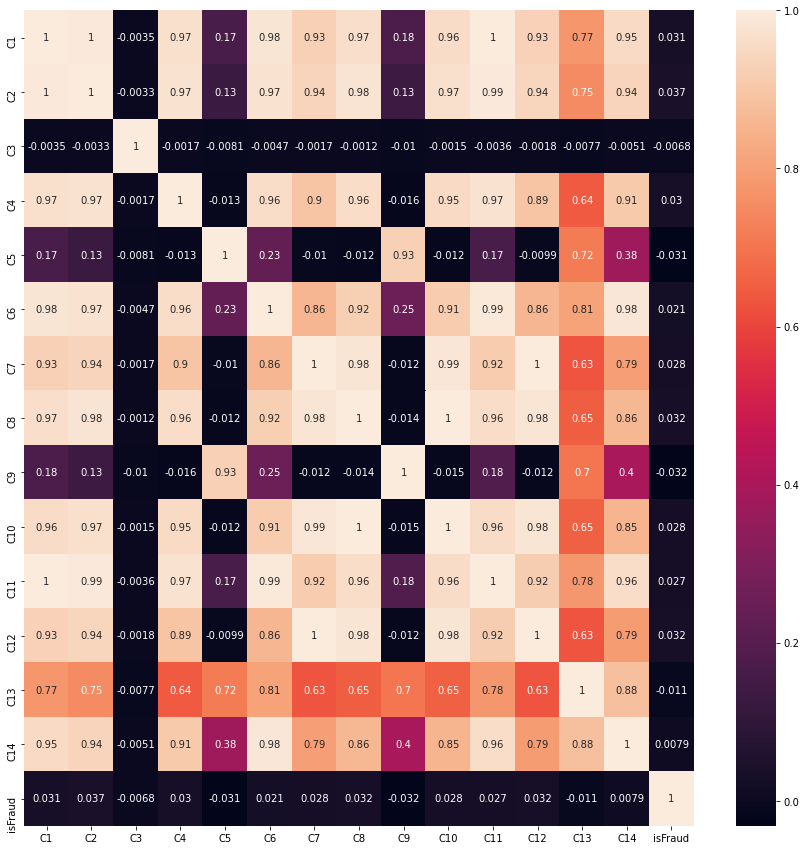

In [99]:
#Checking correlation between C features
plt.figure(figsize=(15,15))
sns.heatmap(C_features.corr(),annot=True)

Many C features are highly correlated with each other.

In [100]:
# Cleaning infinite values to NaN
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   


Data = clean_inf_nan(Data)

In [101]:
def fillna(df):
    df.fillna(-9999, inplace = True)
    
fillna(Data)

In [102]:
Data.shape

(590540, 450)

In [103]:
#Dropping ID Columns
Data.drop(['id_01','id_02','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10','id_11', 'id_12',
'id_15', 'id_16','id_13','id_14','id_17','id_18','id_19','id_20','id_21','id_22','id_23','id_24',
'id_25','id_26','id_27','id_28','id_29','id_32','id_34','id_35','id_36','id_37','id_38','OS_id_30',
'version_id_30', 'screen_width','screen_height','version_id_31','browser_id_31','device_name','TransactionID'], axis=1, inplace=True)

In [104]:
#dropping colums with more than 80% missing values
Data.drop(['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139', 'V140', 'V141',
           'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 
           'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163',
           'V164', 'V165', 'V166', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 
           'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339',  ], axis=1, inplace=True)

In [105]:
##dropping some more columns
Data.drop('R_emaildomain', axis=1, inplace=True)
Data.drop('P_emaildomain', axis=1, inplace=True)
Data.drop('card1', axis=1, inplace=True)
Data.drop('card2', axis=1, inplace=True)
Data.drop('card3', axis=1, inplace=True)
Data.drop('card5', axis=1, inplace=True)
Data.drop('dist1', axis=1, inplace=True)
Data.drop('interval_time', axis=1, inplace=True)
Data.drop('TransactionAmt', axis=1, inplace=True)
Data.drop('device_version', axis=1, inplace=True)

In [106]:
Data.shape

(590540, 342)

In [107]:
#checking categorical variables after feature engineering
cat_variables = list(Data.select_dtypes(include=['object']).columns)
cat_variables

['ProductCD',
 'card4',
 'card6',
 'addr1',
 'addr2',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'DeviceType',
 'P_emaildomain_bin',
 'P_emaildomain_suffix',
 'R_emaildomain_bin',
 'R_emaildomain_suffix']

In [108]:
#missing value imputation of categorical variables with mode
for i in Data.columns: 
    if Data[i].dtypes=='object': Data[i].fillna(Data[i].mode()[0],inplace=True)
        
      

In [109]:
#checking numerical variables after feature engineering
num_variables = list(Data.select_dtypes(exclude=['object']).columns)
num_variables

['isFraud',
 'TransactionDT',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D10',
 'D11',
 'D15',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95',
 'V96',
 'V97',
 'V98',
 'V99',
 'V100',
 'V101',
 'V102'

In [134]:
#Checking outliers
Q1 = Data.quantile(0.25)
Q3 = Data.quantile(0.75)
IQR = Q3 - Q1
C1_IQR = IQR[3]
C1_Q1 = Q1[3]
C1_Q3 = Q3[3]
print(' %d  outliers lower than Q1 - 3*IQR' %len(Data['C1']
[Data['C1'] < (C1_Q1 - 3 * C1_IQR)]))

print(' %d  outliers higher than Q3 + 3*IQR' % len(Data['C1']
[Data['C1'] > (C1_Q3 + 3 * C1_IQR)]))

 0  outliers lower than Q1 - 3*IQR
 43588  outliers higher than Q3 + 3*IQR


In [135]:
#Checking outliers
Q1 = Data.quantile(0.25)
Q3 = Data.quantile(0.75)
IQR = Q3 - Q1
C2_IQR = IQR[3]
C2_Q1 = Q1[3]
C2_Q3 = Q3[3]
print(' %d  outliers lower than Q1 - 3*IQR' %len(Data['C2']
[Data['C2'] < (C2_Q1 - 3 * C2_IQR)]))

print(' %d  outliers higher than Q3 + 3*IQR' % len(Data['C2']
[Data['C2'] > (C2_Q3 + 3 * C2_IQR)]))

 0  outliers lower than Q1 - 3*IQR
 45977  outliers higher than Q3 + 3*IQR


In [136]:
#Checking outliers
Q1 = Data.quantile(0.25)
Q3 = Data.quantile(0.75)
IQR = Q3 - Q1
C3_IQR = IQR[3]
C3_Q1 = Q1[3]
C3_Q3 = Q3[3]
print(' %d  outliers lower than Q1 - 3*IQR' %len(Data['C3']
[Data['C3'] < (C3_Q1 - 3 * C3_IQR)]))

print(' %d  outliers higher than Q3 + 3*IQR' % len(Data['C3']
[Data['C3'] > (C3_Q3 + 3 * C3_IQR)]))

 0  outliers lower than Q1 - 3*IQR
 34  outliers higher than Q3 + 3*IQR


In [137]:
#Checking outliers
Q1 = Data.quantile(0.25)
Q3 = Data.quantile(0.75)
IQR = Q3 - Q1
V1_IQR = IQR[3]
V1_Q1 = Q1[3]
V1_Q3 = Q3[3]
print(' %d  outliers lower than Q1 - 3*IQR' %len(Data['V1']
[Data['V1] < (V1_Q1 - 3 * V1_IQR)]))

print(' %d  outliers higher than Q3 + 3*IQR' % len(Data['V1']
[Data['V1'] > (V1_Q3 + 3 * V1_IQR)]))

 0  outliers lower than Q1 - 3*IQR
 4676  outliers higher than Q3 + 3*IQR


In [138]:
#Checking outliers
Q1 = Data.quantile(0.25)
Q3 = Data.quantile(0.75)
IQR = Q3 - Q1
V5_IQR = IQR[3]
V5_Q1 = Q1[3]
V5_Q3 = Q3[3]
print(' %d  outliers lower than Q1 - 3*IQR' %len(Data['V1']
[Data['V5'] < (V5_Q1 - 3 * V5_IQR)]))

print(' %d  outliers higher than Q3 + 3*IQR' % len(Data['V1']
[Data['V5'] > (V5_Q3 + 3 * V5_IQR)]))

 279287  outliers lower than Q1 - 3*IQR
 0  outliers higher than Q3 + 3*IQR


In [139]:
#Checking outliers
Q1 = Data.quantile(0.25)
Q3 = Data.quantile(0.75)
IQR = Q3 - Q1
D1_IQR = IQR[3]
D1_Q1 = Q1[3]
D1_Q3 = Q3[3]
print(' %d  outliers lower than Q1 - 3*IQR' %len(Data['D1']
[Data['D1'] < (D1_Q1 - 3 * D1_IQR)]))

print(' %d  outliers higher than Q3 + 3*IQR' % len(Data['D1']
[Data['D1'] > (D1_Q3 + 3 * D1_IQR)]))

 1269  outliers lower than Q1 - 3*IQR
 273295  outliers higher than Q3 + 3*IQR


Label Encoding

In [218]:
from sklearn.preprocessing import LabelEncoder, minmax_scale

In [219]:
#Label encoding
categorical_cols = ['ProductCD','card4','card6','addr1','addr2',
       'M1','M2','M3','M4','M5','M6','M7','M8','M9','id_12','id_15','id_16','id_23','id_27','id_28',
        'id_29','id_34','id_35','id_36','id_37','id_38','DeviceType','P_emaildomain_suffix', 'R_emaildomain_suffix','P_emaildomain_bin','R_emaildomain_bin',
                    'OS_id_30',
        'browser_id_31','device_name']
for col in categorical_cols:
    if col in Data.columns:
        le = LabelEncoder()
        le.fit(list(Data[col].astype(str).values)) 
        Data[col] = le.transform(list(Data[col].astype(str).values))

In [220]:
# Cleaning infinite values to NaN
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   
Data = clean_inf_nan(Data)

In [221]:
#replacing NaN
def fillna(df):
    df.fillna(-9999, inplace = True)
    fillna(Data)

In [222]:
Data.shape

(590540, 343)

In [223]:
X_Data=Data.sort_values('TransactionDT').drop(['isFraud','TransactionDT'], axis=1)
Y_Data=Data.sort_values('TransactionDT')['isFraud']

In [ ]:
#Checking correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_Data, 0.80)
print('correlated features: ', len(set(corr_features)) )

In [224]:
X_Data_=X_Data[:80000]
Y_Data_=Y_Data[:80000]

In [225]:
X_Data_.to_csv('X_Data.csv',index=False)
Y_Data_.to_csv('Y_Data.csv',index=False)


In [228]:
# Last month will be our test test (to do test prediction with default parameters)
Data['DT_M'] = Data['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
Data['DT_M'] = (Data['DT_M'].dt.year-2017)*12 + Data['DT_M'].dt.month 

test_ = Data[Data['DT_M']==Data['DT_M'].max()].reset_index(drop=True)
train_ = Data[Data['DT_M']<(Data['DT_M'].max())].reset_index(drop=True)
    
print('Shape control:', train_.shape, test_.shape)

Shape control: (501214, 343) (89326, 343)


In [229]:
X_train_F=train_.sort_values('TransactionDT').drop(['isFraud','TransactionDT'], axis=1)
Y_train_F = train_.sort_values('TransactionDT')['isFraud']
X_test_F=test_.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT'], axis=1)
Y_test_F =test_.sort_values('TransactionDT')['isFraud']

In [230]:
X_train_F=pd.DataFrame(X_train_F)
Y_train_F=pd.DataFrame(Y_train_F)
X_test_F=pd.DataFrame(X_test_F)
Y_test_F=pd.DataFrame(Y_test_F)

In [231]:
X_train_F.to_csv('X_train_F.csv',index=False)
Y_train_F.to_csv('Y_train_F.csv',index=False)
X_test_F.to_csv('X_test_F.csv',index=False)
Y_test_F.to_csv('Y_test_F.csv',index=False)